<a href="https://colab.research.google.com/github/sanjay7178/pytorch-dip/blob/main/PyTorch_Image_Blurring_Color_vs_Monochrome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
from io import BytesIO

class GaussianBlur(nn.Module):
    def __init__(self, kernel_size=15, sigma=3):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.padding = kernel_size // 2

        # Create Gaussian kernel
        x_cord = torch.arange(kernel_size)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

        mean = (kernel_size - 1)/2.
        variance = sigma**2
        gaussian_kernel = torch.exp(
            -torch.sum((xy_grid - mean)**2., dim=-1) / (2*variance)
        )
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

        # Reshape kernel for PyTorch conv2d
        self.gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)

    def forward(self, x):
        # Prepare kernel for different number of channels
        b, c, h, w = x.size()
        kernel = self.gaussian_kernel.repeat(c, 1, 1, 1)

        # Apply gaussian blur
        return F.conv2d(x, kernel, padding=self.padding, groups=c)



In [14]:
def load_and_prepare_image(url):
    # Download and load image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Prepare transformations
    to_tensor = transforms.ToTensor()

    # Convert to tensors
    color_tensor = to_tensor(img)
    gray_tensor = to_tensor(transforms.Grayscale()(img))

    return color_tensor, gray_tensor, img


In [15]:

def tensor_to_image(tensor):
    return transforms.ToPILImage()(tensor)


In [16]:

def plot_results_with_histograms(original_color, blurred_color, original_mono, blurred_mono):
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 4)

    # Plot color images
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(tensor_to_image(original_color))
    ax1.set_title('Original Color')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(tensor_to_image(blurred_color))
    ax2.set_title('Blurred Color')
    ax2.axis('off')

    # Color difference and its histogram
    diff_color = torch.abs(original_color - blurred_color)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(tensor_to_image(diff_color))
    ax3.set_title('Color Difference')
    ax3.axis('off')

    # Color channels histograms
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        ax = fig.add_subplot(gs[0, 3])
        if i == 0:
            ax.set_title('Color Difference Histograms')
        diff_channel = diff_color[i].numpy().flatten() * 255
        ax.hist(diff_channel, bins=50, alpha=0.5, label=color)
        ax.set_xlim([0, 255])
    ax.legend()
    ax.set_xlabel('Difference Intensity')
    ax.set_ylabel('Pixel Count')

    # Plot monochrome images
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.imshow(tensor_to_image(original_mono), cmap='gray')
    ax5.set_title('Original Mono')
    ax5.axis('off')

    ax6 = fig.add_subplot(gs[1, 1])
    ax6.imshow(tensor_to_image(blurred_mono), cmap='gray')
    ax6.set_title('Blurred Mono')
    ax6.axis('off')

    # Mono difference and its histogram
    diff_mono = torch.abs(original_mono - blurred_mono)
    ax7 = fig.add_subplot(gs[1, 2])
    ax7.imshow(tensor_to_image(diff_mono), cmap='gray')
    ax7.set_title('Mono Difference')
    ax7.axis('off')

    ax8 = fig.add_subplot(gs[1, 3])
    diff_mono_data = diff_mono.numpy().flatten() * 255
    ax8.hist(diff_mono_data, bins=50, color='gray')
    ax8.set_title('Mono Difference Histogram')
    ax8.set_xlim([0, 255])
    ax8.set_xlabel('Difference Intensity')
    ax8.set_ylabel('Pixel Count')

    # Add statistics
    stats_ax = fig.add_subplot(gs[2, :])
    stats_ax.axis('off')
    color_stats = f"Color Image Statistics:\n" \
                  f"Original Mean: {original_color.mean().item():.4f}\n" \
                  f"Blurred Mean: {blurred_color.mean().item():.4f}\n" \
                  f"Mean Difference: {diff_color.mean().item():.4f}\n" \
                  f"Max Difference: {diff_color.max().item():.4f}"

    mono_stats = f"Monochrome Image Statistics:\n" \
                 f"Original Mean: {original_mono.mean().item():.4f}\n" \
                 f"Blurred Mean: {blurred_mono.mean().item():.4f}\n" \
                 f"Mean Difference: {diff_mono.mean().item():.4f}\n" \
                 f"Max Difference: {diff_mono.max().item():.4f}"

    stats_ax.text(0.1, 0.6, color_stats, fontsize=10, verticalalignment='top')
    stats_ax.text(0.5, 0.6, mono_stats, fontsize=10, verticalalignment='top')

    plt.tight_layout()
    plt.show()


In [17]:
import torchvision.transforms as T

In [18]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load sample image
    img_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    color_tensor, gray_tensor, original_img = load_and_prepare_image(img_url)

    # Move tensors to device
    color_tensor = color_tensor.unsqueeze(0).to(device)
    gray_tensor = gray_tensor.unsqueeze(0).to(device)

    # Create and apply blur
    blur = T.GaussianBlur(kernel_size=15, sigma=3).to(device)
    with torch.no_grad():
        blurred_color = blur(color_tensor)
        blurred_mono = blur(gray_tensor)

    # Move back to CPU for visualization
    color_tensor = color_tensor.cpu().squeeze(0)
    gray_tensor = gray_tensor.cpu().squeeze(0)
    blurred_color = blurred_color.cpu().squeeze(0)
    blurred_mono = blurred_mono.cpu().squeeze(0)

    # Plot results with histograms
    plot_results_with_histograms(color_tensor, blurred_color, gray_tensor, blurred_mono)


Using device: cpu


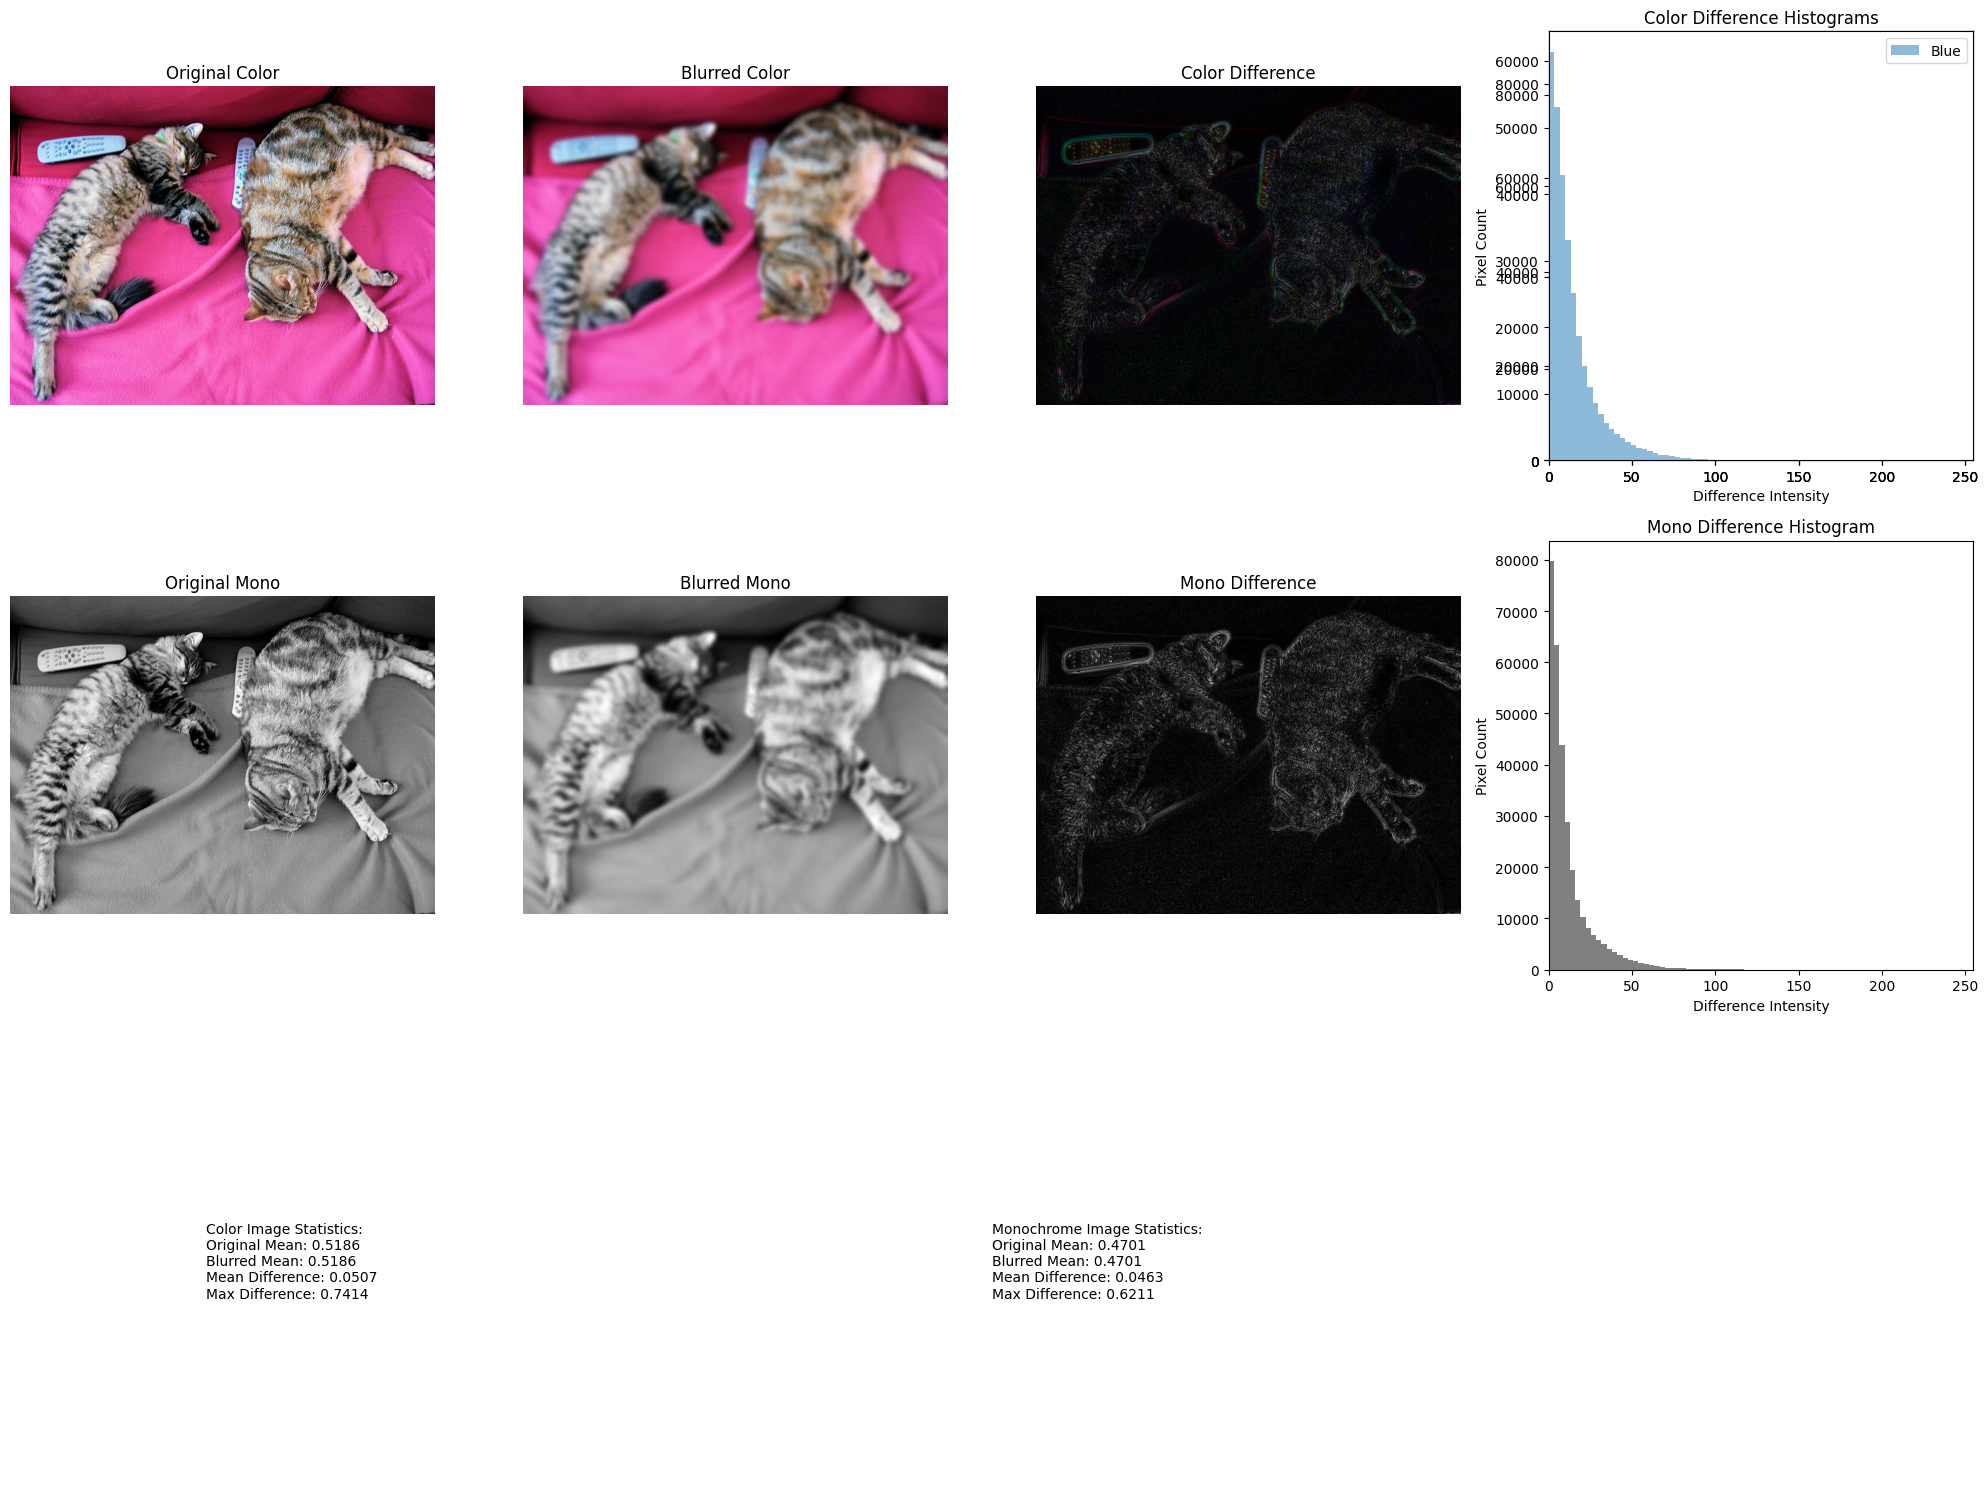

In [21]:
main()